In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. IMPORT LIBRARIES**

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# **2. IMPORTANT VARIABLES**

In [5]:
ROOT_PATH = '/kaggle/input/jmuben-jmuben2-unified-train-val-test/Train_Val_Test'

In [7]:
train_path = os.path.join(ROOT_PATH,'train')
val_path = os.path.join(ROOT_PATH,'val')
test_path = os.path.join(ROOT_PATH,'test')

In [8]:
for folder in os.listdir(ROOT_PATH):
  print(folder)
  for category in os.listdir(os.path.join(ROOT_PATH,folder)):
    print('{}: {} images'.format(category, len(os.listdir(os.path.join(ROOT_PATH,folder,category)))))
  print('')

val
Miner: 1697 images
Leaf rust: 833 images
Cerscospora: 768 images
Phoma: 657 images
Healthy: 1898 images

test
Miner: 1699 images
Leaf rust: 835 images
Cerscospora: 769 images
Phoma: 658 images
Healthy: 1899 images

train
Miner: 13582 images
Leaf rust: 6668 images
Cerscospora: 6144 images
Phoma: 5256 images
Healthy: 15186 images



In [9]:
IMG_SIZE = 224

# **3. SAMPLE OF DATA**

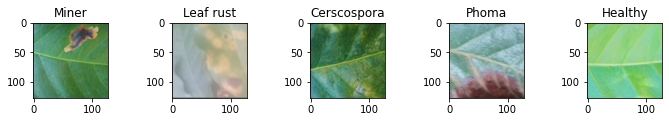

In [10]:
i = np.random.randint(0,100)
classes = os.listdir(train_path)

plt.figure(figsize=(12,8))
plt.subplot(551)
plt.title(classes[0])
plt.imshow(cv.cvtColor(cv.imread(os.path.join(train_path, classes[0], os.listdir(os.path.join(train_path, classes[0]))[i])), cv.COLOR_BGR2RGB))

plt.subplot(552)
plt.title(classes[1])
plt.imshow(cv.cvtColor(cv.imread(os.path.join(train_path, classes[1], os.listdir(os.path.join(train_path, classes[1]))[i])), cv.COLOR_BGR2RGB))

plt.subplot(553)
plt.title(classes[2])
plt.imshow(cv.cvtColor(cv.imread(os.path.join(train_path, classes[2], os.listdir(os.path.join(train_path, classes[2]))[i])), cv.COLOR_BGR2RGB))

plt.subplot(554)
plt.title(classes[3])
plt.imshow(cv.cvtColor(cv.imread(os.path.join(train_path, classes[3], os.listdir(os.path.join(train_path, classes[3]))[i])), cv.COLOR_BGR2RGB))

plt.subplot(555)
plt.title(classes[4])
plt.imshow(cv.cvtColor(cv.imread(os.path.join(train_path, classes[4], os.listdir(os.path.join(train_path, classes[4]))[i])), cv.COLOR_BGR2RGB))

# **4. IMAGE DATA GENERATOR**

In [11]:
generator = ImageDataGenerator(rotation_range=90, 
                              brightness_range=[0.1, 0.7],
                              width_shift_range=0.5, 
                              height_shift_range=0.5,
                              horizontal_flip=True, 
                              vertical_flip=True,
                              preprocessing_function=preprocess_input) 

In [12]:
train_set = generator.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical')

Found 46836 images belonging to 5 classes.


In [14]:
val_set= generator.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical')

Found 5853 images belonging to 5 classes.


In [16]:
test_set = generator.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical', 
    batch_size=1,
    shuffle=False)

Found 5860 images belonging to 5 classes.


# **5. DEFINE MODEL**

In [17]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

2023-02-15 09:20:18.059127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 09:20:18.157720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 09:20:18.158868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 09:20:18.160976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [19]:
for layer in base_model.layers:
  layer.trainable = False

In [20]:
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]
)

# **6. TRAINING**

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False,
)

checkpoint_filepath = ('/kaggle/working/best_VGG16.h5')

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [24]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[early_stopping, checkpoint])

2023-02-15 09:20:50.396155: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-15 09:20:54.992461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1464/1464 [==============================] - 1145s 774ms/step - loss: 0.4680 - tp: 41684.0000 - fp: 4218.0000 - tn: 183126.0000 - fn: 5152.0000 - accuracy: 0.9600 - precision: 0.9081 - recall: 0.8900 - auc: 0.9802 - prc: 0.9457 - val_loss: 0.1629 - val_tp: 5471.0000 - val_fp: 296.0000 - val_tn: 23116.0000 - val_fn: 382.0000 - val_accuracy: 0.9768 - val_precision: 0.9487 - val_recall: 0.9347 - val_auc: 0.9954 - val_prc: 0.9857
Epoch 2/100
1464/1464 [==============================] - 836s 571ms/step - loss: 0.1827 - tp: 43524.0000 - fp: 2454.0000 - tn: 184890.0000 - fn: 3312.0000 - accuracy: 0.9754 - precision: 0.9466 - recall: 0.9293 - auc: 0.9944 - prc: 0.9830 - val_loss: 0.1758 - val_tp: 5464.0000 - val_fp: 311.0000 - val_tn: 23101.0000 - val_fn: 389.0000 - val_accuracy: 0.9761 - val_precision: 0.9461 - val_recall: 0.9335 - val_auc: 0.9948 - val_prc: 0.9838
Epoch 3/100
1464/1464 [==============================] - 826s 564ms/step - loss: 0.1536 - tp: 44018.0000 - fp: 2113.0000 - tn: 18

# **7. TRAINING RESULTS**

In [25]:
def plot_training_results(epochs, train_metrics, val_metrics, y_label):
  plt.plot(epochs, train_metrics,label='train')
  plt.plot(epochs, val_metrics, label='val')
  plt.xlabel('Epochs')
  plt.ylabel(y_label)
  plt.legend

In [26]:
epochs = np.arange(1, len(history.history['loss'])+1)

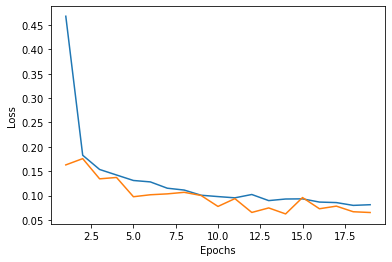

In [27]:
plot_training_results(epochs, history.history['loss'], history.history['val_loss'], 'Loss')

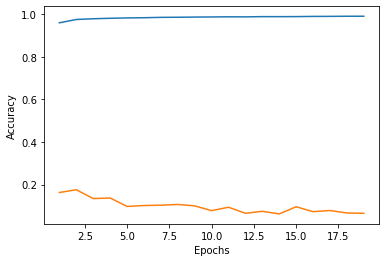

In [28]:
plot_training_results(epochs, history.history['accuracy'], history.history['val_loss'], 'Accuracy')

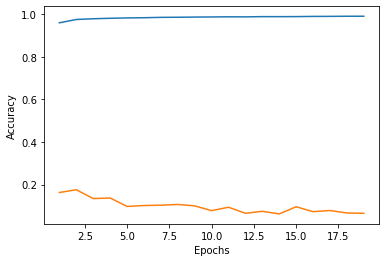

In [29]:
plot_training_results(epochs, history.history['accuracy'], history.history['val_loss'], 'Accuracy')

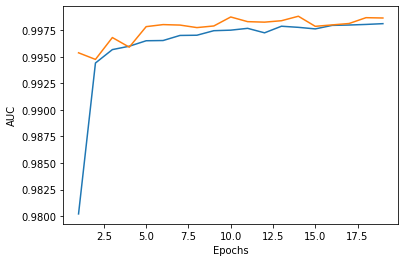

In [30]:
plot_training_results(epochs, history.history['auc'], history.history['val_auc'], 'AUC')

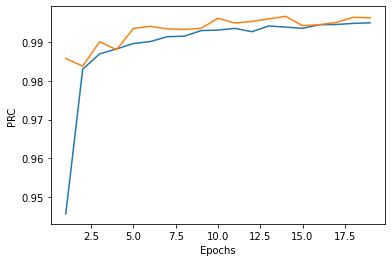

In [31]:
plot_training_results(epochs, history.history['prc'], history.history['val_prc'], 'PRC')

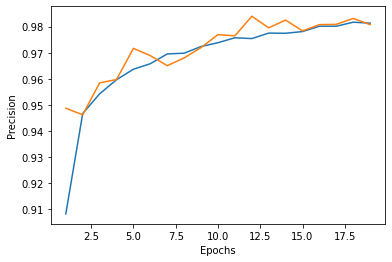

In [32]:
plot_training_results(epochs, history.history['precision'], history.history['val_precision'], 'Precision')

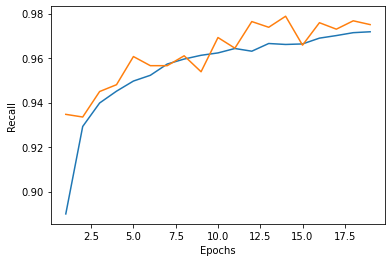

In [33]:
plot_training_results(epochs, history.history['recall'], history.history['val_recall'], 'Recall')

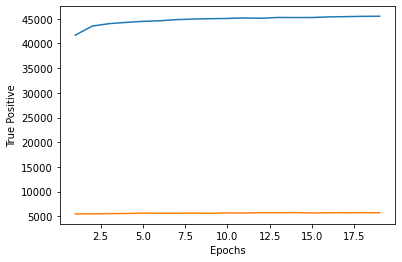

In [34]:
plot_training_results(epochs, history.history['tp'], history.history['val_tp'], 'True Positive')

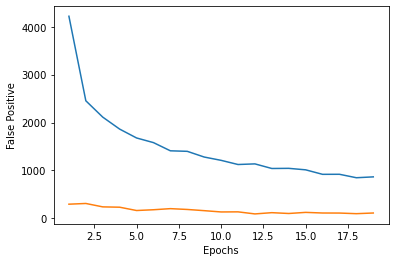

In [35]:
plot_training_results(epochs, history.history['fp'], history.history['val_fp'], 'False Positive')

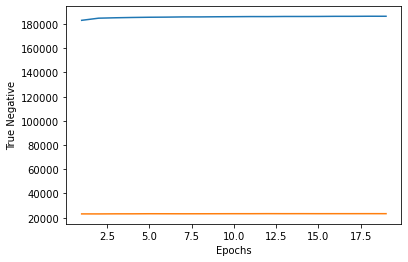

In [36]:
plot_training_results(epochs, history.history['tn'], history.history['val_tn'], 'True Negative')

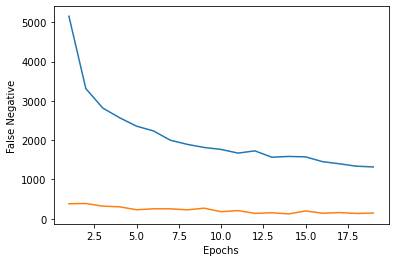

In [37]:
plot_training_results(epochs, history.history['fn'], history.history['val_fn'], 'False Negative')

# **8. TESTING**

In [38]:
best_model = load_model('/kaggle/working/best_VGG16.h5')

In [39]:
best_model.evaluate(test_set)

5860/5860 [==============================] - 147s 25ms/step - loss: 0.0712 - tp: 5715.0000 - fp: 113.0000 - tn: 23327.0000 - fn: 145.0000 - accuracy: 0.9912 - precision: 0.9806 - recall: 0.9753 - auc: 0.9984 - prc: 0.9955


[0.0712379664182663,
 5715.0,
 113.0,
 23327.0,
 145.0,
 0.9911956787109375,
 0.9806108474731445,
 0.9752559661865234,
 0.9983770847320557,
 0.9954674243927002]

In [40]:
y_true = test_set.classes

In [41]:
predictions = best_model.predict(test_set)

In [42]:
y_pred = np.argmax(predictions, axis=1)

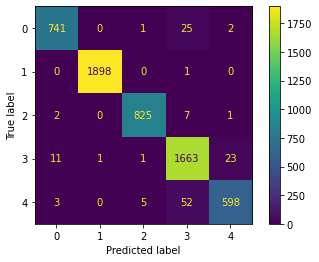

In [48]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [49]:
cm

array([[ 741,    0,    1,   25,    2],
       [   0, 1898,    0,    1,    0],
       [   2,    0,  825,    7,    1],
       [  11,    1,    1, 1663,   23],
       [   3,    0,    5,   52,  598]])

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       769
           1       1.00      1.00      1.00      1899
           2       0.99      0.99      0.99       835
           3       0.95      0.98      0.96      1699
           4       0.96      0.91      0.93       658

    accuracy                           0.98      5860
   macro avg       0.98      0.97      0.97      5860
weighted avg       0.98      0.98      0.98      5860

